##  新闻数据集话题分析
从Scikit-learn库中导入新闻文本数据集(fetch_20newsgroups)，利用Scikit-learn库中的model模型进行话题分析，并绘制出各个主题下的高频词（类似下图所示）。

In [2]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import LatentDirichletAllocation as LDA
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
# 读取数据
data, _ = fetch_20newsgroups(
    shuffle=True,
    random_state=1,
    remove=("headers", "footers", "quotes"),
    return_X_y=True,
)
# 构建词袋模型
count_model=CountVectorizer(max_df=0.5,
                              max_features=2000,
                              stop_words='english') 
word_vector=count_model.fit_transform(data)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


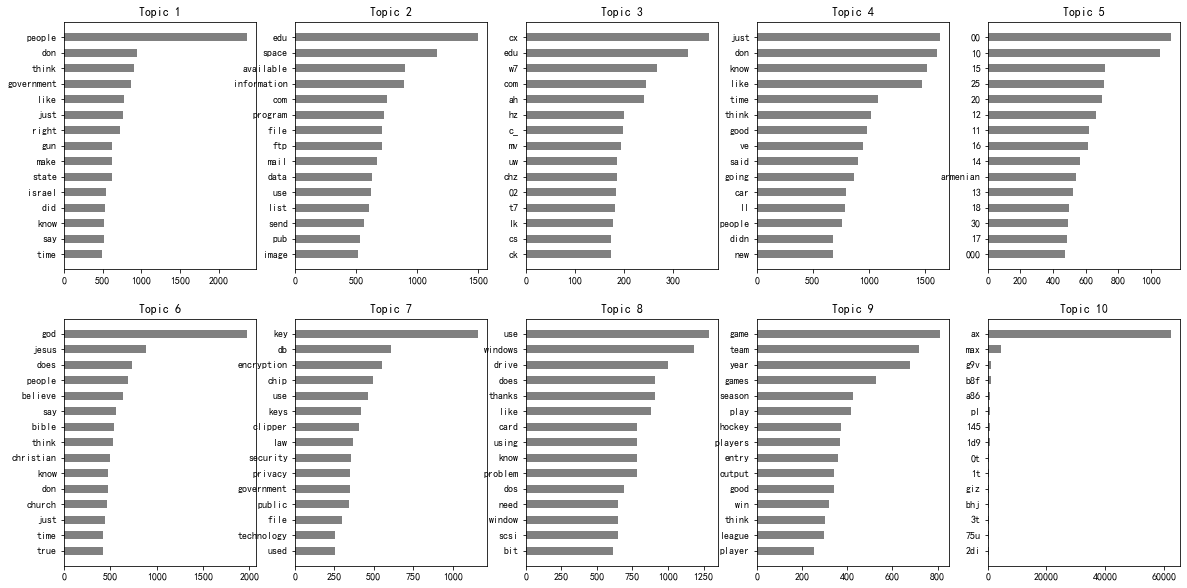

In [3]:
# 主成分分析LDA
model=LDA(n_components=10, max_iter=10, learning_method='batch', verbose=True) 
model.fit(word_vector)
components=model.components_#形状，主题和词条在每个主题的出现概率
plt.figure(figsize=(20,10))
for i in range(10):
    p=np.sort(components[i])[::-1][:15]#对概率降序排列，取前15个
    index=np.argsort(-components[i,])#对概率对应的序号降序排列
    word=np.array(list(count_model.get_feature_names_out()))[index]#根据概率对词进行降序排列
    imword=word[:15]#取出概率最大的15个词
    ax=plt.subplot(2,5,i+1)
    plt.title('Topic %d'%(i+1))
    plt.barh(imword[::-1],p[::-1],height=0.5,color='grey')

# 交大新闻词云
从[交大新闻网主页新闻栏目](http://news.xjtu.edu.cn/zyxw.htm)下载最新的100条新闻报道，利用Scikit-learn库中的LDA模型进行话题分析，并绘制出各个主题下的高频词，以及各个主题的词云。

### (1) 抓取新闻

In [5]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from urllib import parse


class XJTU_News():
    def __init__(self, url):
        self.current_url = url  # 主url可以和path拼接
        self.cookies = {"_ga": "GA1.3.1733503684.1647506450"}
        self.news_urls = []
        self.content = pd.DataFrame(
            columns=["title", "date", "content", "source", "writer"])

    def get_soup(self, url):
        response = requests.get(url, cookies=self.cookies)
        response.encoding = 'UTF-8-SIG'
        soup = BeautifulSoup(response.text, "lxml")
        return soup

    def get_news_list(self, path):
        self.current_url = parse.urljoin(self.current_url, path)
        soup = self.get_soup(self.current_url)
        self.news_urls.extend([parse.urljoin(self.current_url, object["href"])
                              for object in soup.find_all("a", class_="bt")])
        next_page_path = soup.find(
            "span", class_="p_next p_fun").next_element["href"]
        return(next_page_path)

    def get_news_lists(self, number):
        next_page_path = ""
        while(len(self.news_urls) < number):
            next_page_path = self.get_news_list(next_page_path)

    def get_content(self):
        for url in self.news_urls:
            soup = self.get_soup(url)
            title = soup.title.string.split("-西安交通大学")[0]
            try:
                content = soup.find("div", id="vsb_content_2").text.strip()
            except:
                content = None # 有的新闻是视频，所以没有content正文
                print(url)
            writer = soup.find("div", class_="zdf clearfix").text.strip()
            source = None
            date = None
            for temp in soup.find("div", class_="shfffff").contents:
                if "来源" in temp.text:
                    source = temp.text.split("：")[-1].strip()
                elif "日期" in temp.text:
                    date = temp.text.split("：")[-1].strip()
                else:
                    continue
            self.content = self.content.append(
                {"title": title, "date": date, "content": content, "source": source, "writer": writer},ignore_index=True)

In [7]:
main = XJTU_News(url="http://news.xjtu.edu.cn/zyxw.htm")
main.get_news_lists(110)
main.get_content()
main.content.to_csv("result.csv",index = None)

http://news.xjtu.edu.cn/info/1033/182423.htm
http://news.xjtu.edu.cn/info/1033/182267.htm
http://news.xjtu.edu.cn/info/1033/182191.htm
http://news.xjtu.edu.cn/info/1033/182051.htm
http://news.xjtu.edu.cn/info/1033/181932.htm


### （2）分词及数据预处理

In [57]:
import jieba
import pandas as pd
# 仅保留中文
import re
def find_chinese(file):
    pattern = re.compile(r'[^\u3002\uff0c\u4e00-\u9fa5]')
    chinese = re.sub(pattern, '', file)
    return chinese

data = pd.read_csv("result.csv")
data["text"] = data["title"]+data["content"]
data = data[data["text"].notna()][:100] # 删除正文为空的数据
data["text"] = data["text"].apply(lambda x: find_chinese(x))
words=[]
for i in range(data.shape[0]):
    news = ' '.join(jieba.cut(data.iloc[i]["text"]))
    words.append(news)

In [59]:
# 中文停用词表：https://github.com/goto456/stopwords
stopwords = []
f = open("cn_stopwords.txt", "r",encoding='utf-8')
line = f.readline() # 读取第一行
with open("cn_stopwords.txt", "r",encoding='utf-8') as f:
    line = f.readline()
    while line:
        stopwords.append(line[:-1]) # 列表增加
        line = f.readline()

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
count_model = CountVectorizer(max_features=2000,max_df=0.5,min_df = 1,stop_words=stopwords)
word_vector = count_model.fit_transform(words)     # co-occurance matrix
word_vector.shape

(100, 2000)

### (3) LDA模型进行话题分析

In [62]:
n_topics = 5
model=LDA(n_components=n_topics,learning_method="online",learning_offset=50.0,) 
model.fit(word_vector)
components=model.components_#形状，主题和词条在每个主题的出现概率

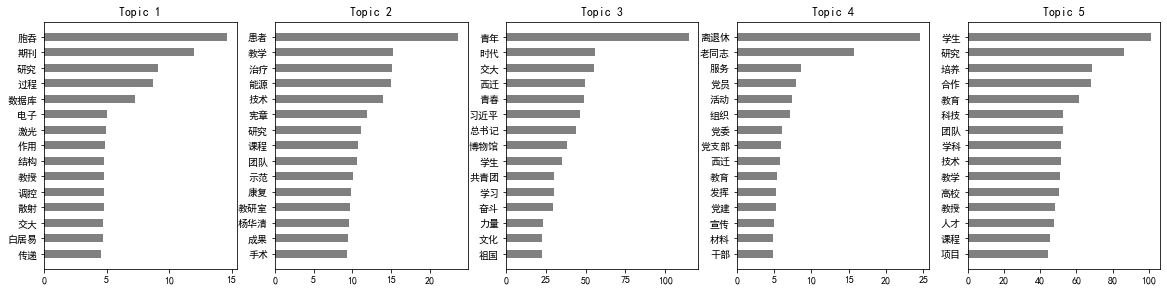

In [64]:
plt.figure(figsize=(20,10))
for i in range(n_topics):
    p=np.sort(components[i])[::-1][:15]#对概率降序排列，取前15个
    index=np.argsort(-components[i,])#对概率对应的序号降序排列
    word=np.array(count_model.get_feature_names_out())[index]#根据概率对词进行降序排列
    imword=word[:15]#取出概率最大的15个词
    ax=plt.subplot(2,5,i+1)
    plt.title('Topic %d'%(i+1))
    plt.barh(imword[::-1],p[::-1],height=0.5,color='grey')

### (4) 绘制词云

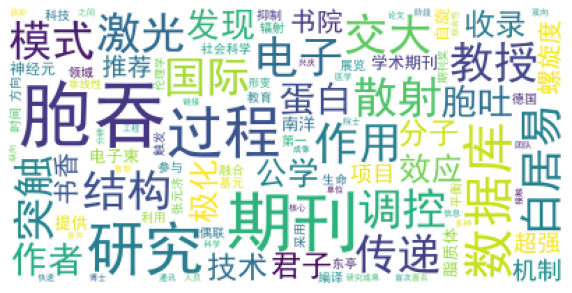

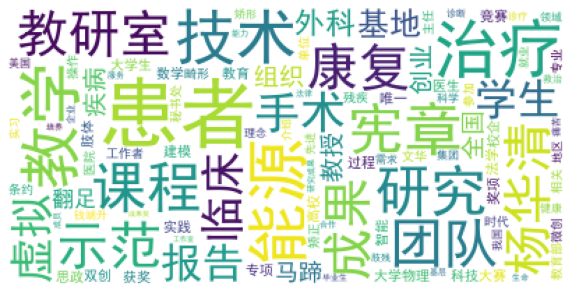

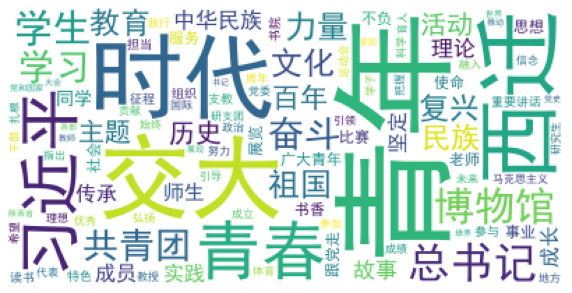

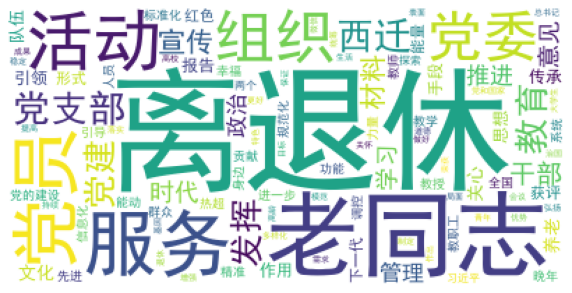

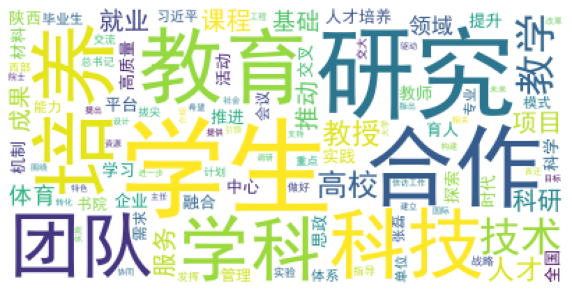

In [66]:
import wordcloud
for i in range(n_topics):
    p=np.sort(components[i])[::-1][:100]
    index=np.argsort(-components[i,])
    word=np.array(list(count_model.get_feature_names()))[index]
    imword=word[:100]
    plt.figure(figsize=(10,10))
    for j in range(len(imword)):
        imword[j] = str(imword[j])
    dic = dict(zip(imword, p)) # 词频以字典形式存储
    cloudobj = wordcloud.WordCloud(font_path='simhei.ttf',background_color="white").generate_from_frequencies(dic)
    plt.imshow(cloudobj)
    plt.axis("off") # 隐藏坐标轴
    plt.show()